In [1]:
import numpy as np
import pylab as plt
from scipy import linalg as la
import scipy.stats as stats
%matplotlib inline
import matplotlib.pylab as plt
import control as ctrl

In [17]:
def numerical_simulation(f,t,x,t0=0.,dt=1e-4,ut=None,ux=None,utx=None,return_u=False):
  """
  simulate x' = f(t,x,u) 

  input:
    f : T x X x U --> X - vector field
      T - time space (subset of real numbers)
      X - state space (must be vector space)
      U - control input set
    t - scalar - final simulation time
    x - initial condition; element of X

    (optional:)
    t0 - scalar - initial simulation time
    dt - scalar - stepsize parameter
    return_u - bool - whether to return u_

    (only one of:)
    ut : R --> U
    ux : X --> U
    utx : R x X --> U

  output:
    t_ - N array - time trajectory
    x_ - N x X array - state trajectory
    (if return_u:)
    u_ - N x U array - state trajectory
  """
  t_,x_,u_ = [t0],[x],[]
  
  inputs = sum([1 if u is not None else 0 for u in [ut,ux,utx]])
  assert inputs <= 1, "more than one of ut,ux,utx defined"

  if inputs == 0:
    assert not return_u, "no input supplied"
  else:
    if ut is not None:
      u = lambda t,x : ut(t)
    elif ux is not None:
      u = lambda t,x : ux(x)
    elif utx is not None:
      u = lambda t,x : utx(t,x)

  while t_[-1]+dt < t:
    if inputs == 0:
      _t,_x = t_[-1],x_[-1]
      dx = f(t_[-1],x_[-1]) * dt
    else:
      _t,_x,_u = t_[-1],x_[-1],u(t_[-1],x_[-1])
      dx = f(_t,_x,_u) * dt
      u_.append( _u )

    x_.append( _x + dx )
    t_.append( _t + dt )

  if return_u:
    return np.asarray(t_),np.asarray(x_),np.asarray(u_)
  else:
    return np.asarray(t_),np.asarray(x_)

# CT-LQR infinite horizon

In [85]:
T = 10 #total time (s)
dt = 1e-2
I = 6 #kg, inertia
D = -0.2 #N/m damping
G = np.array([[10,0],[0,1]]) #Gamma, observer gain
Q = np.array([[100,0],[0,0]])
Qh = np.array([[100,0],[0,0]])
R = np.array([[1]])

A = np.array([[0,1],[0,-(1/I)*D]])
B = np.array([[0],[1/I]])

#initial state (x-xd)
s0 = np.array([-0.1,0]) # start with position 0, i.e. s = x-xd = 0-0.1

#10 reach back and forward (-10 ~ +10 cm), step "ref"
# ref = np.array([0.1,-0.1,0.1,-0.1,0.1,-0.1,0.1,-0.1,0.1,-0.1,0.1,-0.1,0.1,-0.1,0.1,-0.1,0.1,-0.1,0.1,-0.1])
# xd = np.repeat(ref, int(T/10/dt)/2)

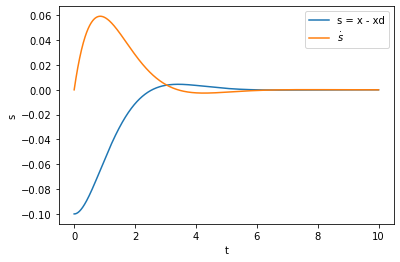

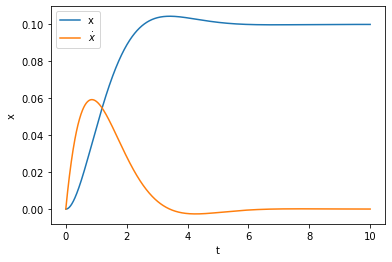

In [86]:
# (1) CT-LQR
K,_,_ = ctrl.lqr(A,B,Q,R)

def f(t,s,u):
    return np.dot(A,s) + np.dot(B,u)
us = lambda x: -np.dot(K,x)

t_,s_ = numerical_simulation(f,T,s0,t0=0.,dt=dt,ux=us)

plt.plot(t_,s_[:,0], label= 's = x - xd')
plt.plot(t_,s_[:,1], label= r'$\dot s$')
plt.ylabel('s')
plt.xlabel('t')
plt.legend()
plt.show()

xd = np.zeros((len(t_))) + 0.1 #make xd a fixed target of 10 cm
plt.plot(t_,s_[:,0]+ xd, label= 'x')
plt.plot(t_,s_[:,1], label= r'$\dot x$')
plt.ylabel('x')
plt.xlabel('t')
plt.legend()
plt.show()

# DT-LQR infinite horizon

## robot/human alone Q = diag(200,0)

In [1014]:
# (1) DT-LQR infinite horizon
T = 10 #total time (s)
dt = 1e-2
t_ = np.linspace(0,T,int(T/dt))
I = 6 #kg, inertia
D = -0.2 #N/m damping

A = np.identity(2) + dt * np.array([[0, 1],[0,-(1/I)*D]])
B = dt * np.array([[0],[1/I]])
Q = dt * np.array([[200,0],[0,0]]) # running state cost
R = dt * np.array([[1]]) # running control cost
P = la.solve_discrete_are(A,B,Q,R)
K,_,_ = ctrl.dlqr(A,B,Q,R) #np.dot(la.inv(R + B.T@P@B),(B.T@P@A))

#initial state (x-xd)
xd = 0.1 #target = 10cm
ds0 = np.array([0-xd,0]) # start with position 0, i.e. s = x-xd = 0-0.1
ds = np.zeros((int(T/dt)+1,2))
ds[0] = ds0
du = np.zeros((int(T/dt),1)) 
c = np.zeros((int(T/dt),1)) #cost

for t in range(int(T/dt)):
  du[t] = np.dot(-K,ds[t]) + 0.1*(np.random.rand() - 0.5)                        # calculate optimal input (noisy)      
  ds[t+1] = np.dot(A,ds[t]) + np.dot(B, du[t])        # calculate next state
  c[t] = np.dot(np.dot(ds[t],Q),ds[t]) + np.dot(np.dot(du[t],R),du[t])

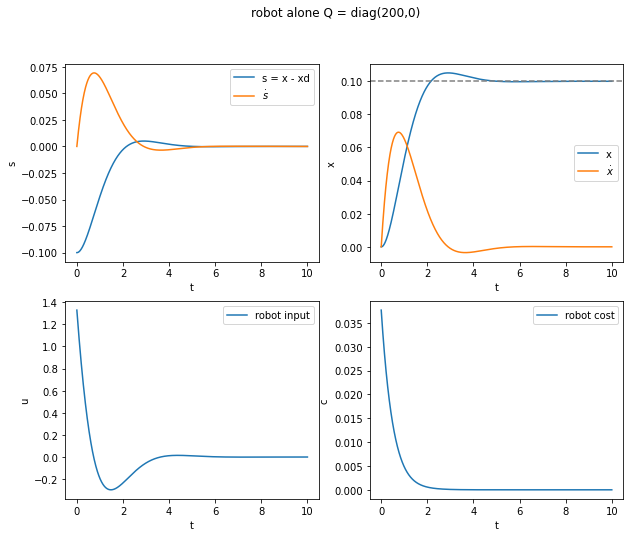

In [1015]:
fig,axs = plt.subplots(2,2,figsize = (10,8))
ax = axs[0,0]
ax.plot(t_,ds[:-1,0], label= 's = x - xd')
ax.plot(t_,ds[:-1,1], label= r'$\dot s$')
ax.set_ylabel('s')
ax.set_xlabel('t')

ax.legend()

ax = axs[0,1]
# xd = np.zeros((len(t_))) + 0.1 #make xd a fixed target of 10 cm
ax.plot(t_,ds[:-1,0]+ xd, label= 'x')
ax.plot(t_,ds[:-1,1], label= r'$\dot x$')
ax.axhline(y=0.1, color='grey', linestyle='--')
ax.set_ylabel('x')
ax.set_xlabel('t')
ax.legend()

ax = axs[1,0]
ax.plot(t_,du, label= 'robot input')
ax.set_ylabel('u')
ax.set_xlabel('t')
ax.legend()

ax = axs[1,1]
ax.plot(t_,c, label= 'robot cost')
ax.set_ylabel('c')
ax.set_xlabel('t')
ax.legend()

fig.suptitle('robot alone Q = diag(200,0)')
# plt.tight_layout()
plt.show()

## coactivity, two indep LQR: Q = Qh = diag(100,0)

In [1169]:
# DT-LQR
T = 10 #total time (s)
dt = 1e-2
t_ = np.linspace(0,T,int(T/dt))
A = np.identity(2) + dt * np.array([[0, 1],[0,-(1/I)*D]])
B = dt * np.array([[0],[1/I]])
Q = dt * np.array([[100,0],[0,0]]) # running state cost
QH = dt * np.array([[100,0],[0,0]]) # running state cost
R = dt * np.array([[1]]) # running control cost

P = la.solve_discrete_are(A,B,Q,R)
PH = la.solve_discrete_are(A,B,QH,R)
K,_,_ = ctrl.dlqr(A,B,Q,R) #np.dot(la.inv(R + B.T@P@B),(B.T@P@A))
KH,_,_ = ctrl.dlqr(A,B,QH,R) #np.dot(la.inv(R + B.T@P@B),(B.T@P@A))


#initial state (x-xd)
ds0 = np.array([-0.1,0]) # start with position 0, i.e. s = x-xd = 0-0.1
ds = np.zeros((int(T/dt)+1,2))
ds[0] = ds0
du = np.zeros((int(T/dt),1))  #robot input
duH = np.zeros((int(T/dt),1))  #human input noisy, and with an error of 5% smaller 
c = np.zeros((int(T/dt),1))  #robot cost
cH = np.zeros((int(T/dt),1)) #cost human

for t in range(int(T/dt)):
  du[t] = np.dot(-K,ds[t])                       # calculate optimal input
  duH[t] = 0.95*(np.dot(-KH,ds[t]) + 0.1*(np.random.rand() - 0.5))                       # calculate optimal input    
  ds[t+1] = np.dot(A,ds[t]) + np.dot(B, du[t]+duH[t])        # calculate next state
  c[t] = np.dot(np.dot(ds[t],Q),ds[t]) + np.dot(np.dot(du[t],R),du[t])
  cH[t] = np.dot(np.dot(ds[t],QH),ds[t]) + np.dot(np.dot(duH[t],R),duH[t])


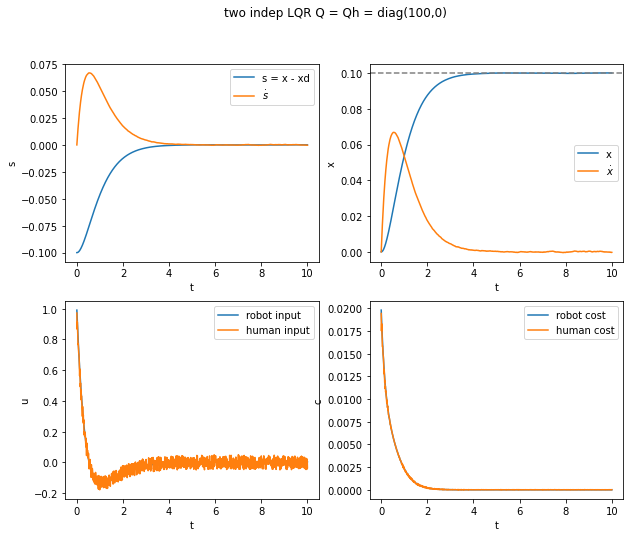

In [1019]:
fig,axs = plt.subplots(2,2,figsize = (10,8))
ax = axs[0,0]
ax.plot(t_,ds[:-1,0], label= 's = x - xd')
ax.plot(t_,ds[:-1,1], label= r'$\dot s$')
ax.set_ylabel('s')
ax.set_xlabel('t')
ax.legend()

ax = axs[0,1]
# xd = np.zeros((len(t_))) + 0.1 #make xd a fixed target of 10 cm
ax.plot(t_,ds[:-1,0]+ xd, label= 'x')
ax.plot(t_,ds[:-1,1], label= r'$\dot x$')
ax.axhline(y=0.1, color='grey', linestyle='--')
ax.set_ylabel('x')
ax.set_xlabel('t')
ax.legend()

ax = axs[1,0]
ax.plot(t_,du, label= 'robot input')
ax.plot(t_,duH, label= 'human input')
ax.set_ylabel('u')
ax.set_xlabel('t')
ax.legend()

ax = axs[1,1]
ax.plot(t_,c, label= 'robot cost')
ax.plot(t_,cH, label= 'human cost')
ax.set_ylabel('c')
ax.set_xlabel('t')
ax.legend()

fig.suptitle('two indep LQR Q = Qh = diag(100,0)')
# plt.tight_layout()
plt.show()

In [633]:
K

array([[ 9.90746904, 11.15510224]])

In [347]:
la.norm(K)

14.919592778119537

# GT Algorithm

## collabration: Q = Qh = diag(100,0)

Both agents have no initial knowledge of the partner's control (i.e. PHh = 0 and Ph = 0)

In [1252]:
# collabration, robot: Q, human: Qh
t = 0

#DT system
T = 10 #total time (s)
dt = 1e-2
t_ = np.linspace(0,T,int(T/dt))
A = np.identity(2) + dt * np.array([[0, 1],[0,-(1/I)*D]])
B = dt * np.array([[0],[1/I]])
R = dt * np.array([[1]]) # running control cost

xd = 0.1 #target position +10cm

#initialize Q, QHh, u, uHh, sh, PHh
x = np.zeros((int(T/dt)+1,2)) #x[0] = position, x[1] = velocity
s = np.zeros((int(T/dt)+1,2)) #state, s = x-xd
s[0] = np.array([x[0,0]-xd,x[0,1]]) #get position and velocity, form the state s
sh = np.zeros((int(T/dt)+1,2)) #estimated state
sh[0] = np.array([x[0,0]-xd,x[0,1]]) 
se = np.zeros((int(T/dt)+1,2)) #state estimation error

sHh = np.zeros((int(T/dt)+1,2)) #estimated state
sHh[0] = np.array([x[0,0]-xd,x[0,1]]) 
sHe = np.zeros((int(T/dt)+1,2)) #state estimation error

#human
QH = dt * np.array([[100,0],[0,0]])  #human running state cost, fixed, time-invariant
PH = np.zeros((int(T/dt),2,2)) # P that solves the riccati eqn
PH[0] = la.solve_discrete_are(A,B,QH,R)
LH = np.zeros((int(T/dt),1,2))
LH[0] = ctrl.dlqr(A,B,QH,R)[0] #np.dot(la.inv(R + B.T@P@B),(B.T@P@A))
uH = np.zeros((int(T/dt),1)) #robot and human inputs
uH[0] = np.dot(-LH[0],s[0])
cH = np.zeros((int(T/dt),1))
cH[0] = np.dot(np.dot(s[0],QH),s[0]) + np.dot(np.dot(uH[0],R),uH[0])  #human cost
AH = np.identity(2) + dt * np.array([[0, 1],[0,-(1/I)*D]]) #AH[0] = A

#robot
Q = dt * np.array([[100,0],[0,0]])  #robot running state cost, time-invariant
P = np.zeros((int(T/dt),2,2)) #robot P that solves the riccati eqn
P[0] = la.solve_discrete_are(A,B,Q,R)
L = np.zeros((int(T/dt),1,2))
L[0] = ctrl.dlqr(A,B,Q,R)[0] #np.dot(la.inv(R + B.T@P@B),(B.T@P@A))
u = np.zeros((int(T/dt),1)) 
u[0] = np.dot(-L[0],s[0])
c = np.zeros((int(T/dt),1))
c[0] = np.dot(np.dot(s[0],Q),s[0]) + np.dot(np.dot(u[0],R),u[0])
Ar = np.identity(2) + dt * np.array([[0, 1],[0,-(1/I)*D]]) #Ar[0] = A

#robot's estimate of human
QHh = np.zeros((int(T/dt),2,2))  #robot estimate human running state cost, time-variant
# QHh[0] = dt * np.array([[100,0],[0,0]])
PHh = np.zeros((int(T/dt),2,2)) #human P that solves the riccati eqn
# PHh[0] = la.solve_discrete_are(A,B,QHh[0],R)
LHh = np.zeros((int(T/dt),1,2))
# LHh[0] = ctrl.dlqr(A,B,QHh[0],R)[0]
uHh = np.zeros((int(T/dt),1)) 
# uHh[0] = np.dot(-LHh[0],s[0])
cHh = np.zeros((int(T/dt),1))
AHh = np.identity(2) + dt * np.array([[0, 1],[0,-(1/I)*D]]) #AH[0] = A

#human's estimate of robot
Qh = np.zeros((int(T/dt),2,2))  #robot estimate human running state cost, time-variant
# Qh[0] = dt * np.array([[100,0],[0,0]])
Ph = np.zeros((int(T/dt),2,2)) #robot P that solves the riccati eqn
# Ph[0] = la.solve_discrete_are(A,B,Qh[0],R)
Lh = np.zeros((int(T/dt),1,2))
# Lh[0] = ctrl.dlqr(A,B,Qh[0],R)[0]
uh = np.zeros((int(T/dt),1)) 
# uh[0] = np.dot(-Lh[0],s[0])
ch = np.zeros((int(T/dt),1))
Arh = np.identity(2) + dt * np.array([[0, 1],[0,-(1/I)*D]]) #AH[0] = A

#set Gamma and alpha
G = dt * np.array([[100,0],[0,1]]) #Gamma, observer gain
a = 10**4 #machine learning rate
aH = 10**4 #human learning rate


In [1244]:
PHh

array([[[110.57417584,  60.56037093],
        [ 60.56037093,  67.55852733]],

       [[109.57417584,  60.56037093],
        [ 60.56037093,  67.55852733]],

       [[108.57417584,  60.59339583],
        [ 60.60990828,  67.55689137]],

       ...,

       [[ 32.03372745, 111.11489218],
        [ 78.51893346,  62.00003507]],

       [[ 32.03372745, 111.11489218],
        [ 78.51893345,  62.00003508]],

       [[  0.        ,   0.        ],
        [  0.        ,   0.        ]]])

In [1245]:
P

array([[[110.57417584,  60.56037093],
        [ 60.56037093,  67.55852733]],

       [[ 75.59482645,  25.16446271],
        [ 25.16446271,  12.63830558]],

       [[ 75.56463322,  25.15004441],
        [ 25.15004441,  12.63186021]],

       ...,

       [[ 65.8126129 ,  20.79676647],
        [ 20.79676647,  11.36475183]],

       [[ 65.81261291,  20.79676647],
        [ 20.79676647,  11.36475183]],

       [[ 65.81261291,  20.79676647],
        [ 20.79676647,  11.36475183]]])

In [1241]:
t = 1
P[t-1] + dt * a * np.outer( (se[t-1]-s[t-1]), s[t-1] ) 

array([[109.57417584,  60.56037093],
       [ 60.56037093,  67.55852733]])

In [1253]:
#start with t = 1
for t in range(1,int(T/dt)):

    s[t] = np.dot(A,s[t-1]) + np.dot(B, u[t-1]+uH[t-1])  
    
    '''ROBOT'''
    # closed loop system observer
    # (1) calculate the estimation error se and estimated state sh
    sh[t] = np.dot(A,sh[t-1]) + np.dot(B, u[t-1]+uHh[t-1]) - np.dot(G,se[t-1])
    se[t] = sh[t] - s[t]

    # (2) estimate control of human
    # update PHh, and estimated human control gain L and u = -Ls
    PHh[t] = PHh[t-1] + dt * a * np.outer( (se[t-1]-s[t-1]), s[t-1] ) 
    LHh[t] = (la.inv(R+B.T@PHh[t]@B))@(B.T@PHh[t]@AH)  
    uHh[t] = np.dot(-LHh[t],s[t])

    # (3) robot's control input
    Ar = A - np.dot(B,LHh[t])
    P[t] = la.solve_discrete_are(Ar,B,Q,R)
    L[t] = (la.inv(R+B.T@P[t]@B))@(B.T@P[t]@Ar) 
    u[t] = np.dot(-L[t],s[t]) #output 

    # (4) calculate estimated human cost function QHh (from DARE)
    AHh = A - np.dot(B,L[t])
    QHh[t] = PHh[t] - AHh.T@PHh[t]@AHh + AHh.T@PHh[t]@B@ (la.inv(R+B.T@PHh[t]@B)) @B.T@PHh[t]@AHh #output

    '''HUMAN'''
    # (1)
    sHh[t] = np.dot(A,sh[t-1]) + np.dot(B, uH[t-1]+uh[t-1]) - np.dot(G,sHe[t-1])
    sHe[t] = sHh[t] - s[t]

    # (2) estimate control of robot
    # update PHh, and estimated robot control gain L and u = -Ls
    Ph[t] = Ph[t-1] + dt * aH * np.outer( (sHe[t-1]-s[t-1]), s[t-1] ) 
    Lh[t] = (la.inv(R+B.T@Ph[t]@B))@(B.T@Ph[t]@AH) 
    uh[t] = np.dot(-Lh[t],s[t])

    # (3) human control input (what human is actually doing)
    AH = A - np.dot(B,Lh[t])
    PH[t] = la.solve_discrete_are(AH,B,QH,R) #fixed QH
    LH[t] = (la.inv(R+B.T@PH[t]@B))@(B.T@PH[t]@AH) #if CT: np.dot (B.T , P[t]) 
    uH[t] = np.dot(-LH[t],s[t])#0.95* (np.dot(-LH[t],s[t])) #output smaller than real

    # (4) calculate estimated robot cost function Qh (from DARE)
    Arh = A - np.dot(B,LH[t])
    Qh[t] = Ph[t] - Arh.T@Ph[t]@Arh + Arh.T@Ph[t]@B@ (la.inv(R+B.T@Ph[t]@B)) @B.T@Ph[t]@Arh #output

    #costs
    c[t] = np.dot(np.dot(s[t],Q),s[t]) + np.dot(np.dot(u[t],R),u[t]) #machine cost
    ch[t] = np.dot(np.dot(s[t],Qh[t]),s[t]) + np.dot(np.dot(uh[t],R),uh[t])  #estimated machine cost
    cH[t] = np.dot(np.dot(s[t],QH),s[t]) + np.dot(np.dot(uH[t],R),uH[t])  #human cost
    cHh[t] = np.dot(np.dot(s[t],QHh[t]),s[t]) + np.dot(np.dot(uHh[t],R),uHh[t])  #estimated human cost   
   

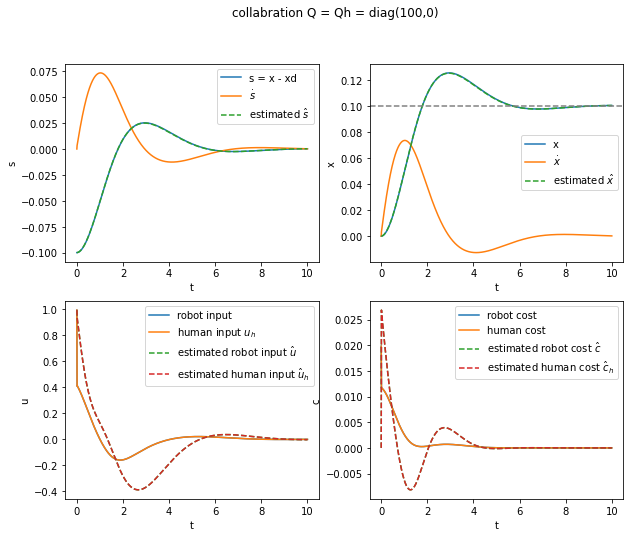

In [1254]:
fig,axs = plt.subplots(2,2,figsize = (10,8))
ax = axs[0,0]
ax.plot(t_,s[:-1,0], label= 's = x - xd')
ax.plot(t_,s[:-1,1], label= r'$\dot s$')
ax.plot(t_,sh[:,0][:-1], '--',label= r'estimated $\hat s$')
ax.set_ylabel('s')
ax.set_xlabel('t')
ax.legend()

ax = axs[0,1]
# xd = np.zeros((len(t_))) + 0.1 #make xd a fixed target of 10 cm
ax.plot(t_,s[:-1,0]+ xd, label= 'x')
ax.plot(t_,s[:-1,1], label= r'$\dot x$')
ax.plot(t_,sh[:,0][:-1]+ xd, '--',label= r'estimated $\hat x$')
ax.axhline(y=0.1, color='grey', linestyle='--')
ax.set_ylabel('x')
ax.set_xlabel('t')
ax.legend()

ax = axs[1,0]
ax.plot(t_,u, label= 'robot input')
ax.plot(t_,uH, label= 'human input $u_h$')
ax.plot(t_,uh, '--',label= 'estimated robot input $\hat u$')
ax.plot(t_,uHh, '--',label= 'estimated human input $\hat u_h$')
ax.set_ylabel('u')
ax.set_xlabel('t')
ax.legend()

ax = axs[1,1]
ax.plot(t_,c, label= 'robot cost')
ax.plot(t_,cH, label= 'human cost')
ax.plot(t_,ch, '--',label= 'estimated robot cost $\hat c$')
ax.plot(t_,cHh, '--',label= 'estimated human cost $\hat c_h$')
ax.set_ylabel('c')
ax.set_xlabel('t')
ax.legend()

fig.suptitle('collabration Q = Qh = diag(100,0)')
# plt.tight_layout()
plt.show()

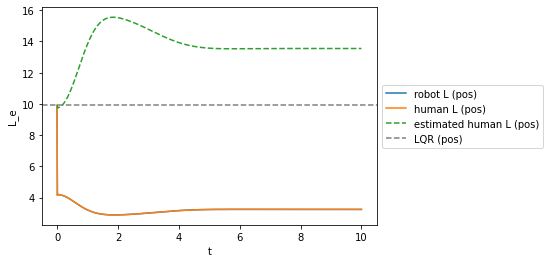

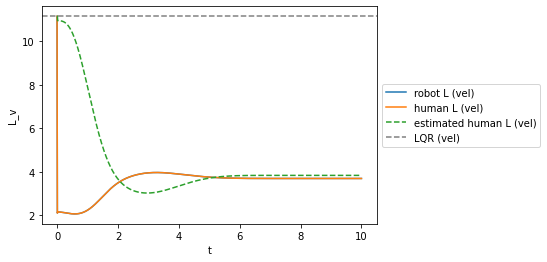

In [1256]:
plt.plot(t_,L[:,:,0], label= 'robot L (pos)')
plt.plot(t_,LH[:,:,0], label= 'human L (pos)')
plt.plot(t_,LHh[:,:,0],'--', label= 'estimated human L (pos)')
plt.axhline(y=K[0,0], color='grey', linestyle='--', label= 'LQR (pos)')
plt.ylabel('L_e')
plt.xlabel('t')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.plot(t_,L[:,:,1],  label= 'robot L (vel)')
plt.plot(t_,LH[:,:,1], label= 'human L (vel)')
plt.plot(t_,LHh[:,:,1], '--',label= 'estimated human L (vel)')
plt.axhline(y=K[0,1], color='grey', linestyle='--', label= 'LQR (vel)')
plt.ylabel('L_v')
plt.xlabel('t')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

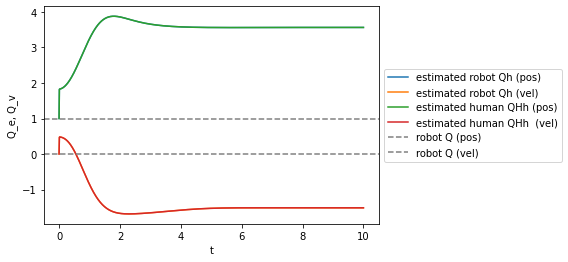

In [1257]:
plt.plot(t_,Qh[:,0,0],  label= 'estimated robot Qh (pos)')
plt.plot(t_,Qh[:,1,1], label= 'estimated robot Qh (vel)')
plt.plot(t_,QHh[:,0,0],  label= 'estimated human QHh (pos)')
plt.plot(t_,QHh[:,1,1], label= 'estimated human QHh  (vel)')
plt.axhline(y=Q[0,0], color='grey', linestyle='--', label= 'robot Q (pos)')
plt.axhline(y=Q[1,1], color='grey', linestyle='--', label= 'robot Q (vel)')

# plt.axhline(y=QH[0,0], color='grey', linestyle='--', label= 'human Q (pos)')
plt.ylabel('Q_e, Q_v')
plt.xlabel('t')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [1139]:
Qh[:]

array([[[ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00]],

       [[ 0.00000000e+00,  1.00000000e-02],
        [ 1.00000000e-02,  1.00000000e-04]],

       [[ 1.36269736e-03,  2.05843429e-02],
        [ 2.08829488e-02, -6.69720075e-04]],

       ...,

       [[ 2.80333000e-01,  2.49369911e+00],
        [ 9.49469938e-01,  1.86137673e-01]],

       [[ 2.80332933e-01,  2.49369916e+00],
        [ 9.49469916e-01,  1.86137707e-01]],

       [[ 2.80332867e-01,  2.49369921e+00],
        [ 9.49469895e-01,  1.86137742e-01]]])

In [1138]:
Qh[:,0,0]

array([0.        , 0.        , 0.0013627 , ..., 0.280333  , 0.28033293,
       0.28033287])

In [1096]:
QH

array([[1., 0.],
       [0., 0.]])

In [ ]:
# start with t = 0
# for t in range(int(T/dt)):

#     '''ROBOT'''
#     # closed loop system observer
#     # (1) calculate the estimation error se and estimated state sh
#     se[t] = sh[t] - s[t]
#     sh[t+1] = np.dot(A,sh[t]) + np.dot(B, u[t]+uHh[t]) - np.dot(G,se[t])

#     # (2) identity control of human
#     # update PHh, and estimated human control gain L and u = -Ls
#     PHh[t+1] = PHh[t] + dt * a * np.outer( (se[t]-s[t]), s[t] ) 
#     LHh[t] = (la.inv(R+B.T@PHh[t]@B))@(B.T@PHh[t]@AH) #if CT: np.dot (B.T , PHh[t]) 
#     uHh[t] = np.dot(-LHh[t],s[t])

#     # (3) robot's control input
#     Ar = A - np.dot(B,LHh[t])
#     P[t] = la.solve_discrete_are(Ar,B,Q,R)
#     L[t] = (la.inv(R+B.T@P[t]@B))@(B.T@P[t]@Ar) #if CT: np.dot (B.T , P[t]) 
#     u[t] = np.dot(-L[t],s[t]) #output 

#     # (4) calculate estimated human cost function QHh (from DARE)
#     AHh = A - np.dot(B,L[t])
#     QHh[t] = PHh[t] - AHh.T@PHh[t]@AHh + AHh.T@PHh[t]@B@ (la.inv(R+B.T@PHh[t]@B)) @B.T@PHh[t]@AHh #output

#     '''HUMAN'''
#     # (1)
#     sHe[t] = sHh[t] - s[t]
#     sHh[t+1] = np.dot(A,sh[t]) + np.dot(B, uH[t]+uh[t]) - np.dot(G,sHe[t])

#     # (2) identity control of robot
#     # update PHh, and estimated robot control gain L and u = -Ls
#     Ph[t+1] = Ph[t] + dt * aH * np.outer( (sHe[t]-s[t]), s[t] ) 
#     Lh[t] = (la.inv(R+B.T@Ph[t]@B))@(B.T@Ph[t]@AH) #if CT: np.dot (B.T , PHh[t]) 
#     uh[t] = np.dot(-Lh[t],s[t])

#     # (3) human control input (what human is actually doing)
#     AH = A - np.dot(B,Lh[t])
#     PH[t] = la.solve_discrete_are(AH,B,QH,R) #fixed QH
#     LH[t] = (la.inv(R+B.T@PH[t]@B))@(B.T@PH[t]@AH) #if CT: np.dot (B.T , P[t]) 
#     uH[t] = np.dot(-LH[t],s[t])#0.95* (np.dot(-LH[t],s[t])) #output smaller than real

#     # (4) calculate estimated robot cost function Qh (from DARE)
#     Arh = A - np.dot(B,LH[t])
#     Qh[t] = Ph[t] - Arh.T@Ph[t]@Arh + Arh.T@Ph[t]@B@ (la.inv(R+B.T@Ph[t]@B)) @B.T@Ph[t]@Arh #output

#     #costs
#     c[t] = np.dot(np.dot(s[t],Q),s[t]) + np.dot(np.dot(u[t],R),u[t]) #machine cost
#     ch[t] = np.dot(np.dot(s[t],Qh[t]),s[t]) + np.dot(np.dot(uh[t],R),uh[t])  #estimated machine cost
#     cH[t] = np.dot(np.dot(s[t],QH),s[t]) + np.dot(np.dot(uH[t],R),uH[t])  #human cost
#     cHh[t] = np.dot(np.dot(s[t],QHh[t]),s[t]) + np.dot(np.dot(uHh[t],R),uHh[t])  #estimated human cost

#     # calculate next state
#     s[t+1] = np.dot(A,s[t]) + np.dot(B, u[t]+uH[t])  
   

In [964]:
# #at t = 0
# se[t] = sh[t] - s[t]
# sh[t+1] = np.dot(A,sh[t]) + np.dot(B, u[t]+uHh[t]) - np.dot(G,se[t])

# #human estimates what robot is doing :
# P[0] = 0
# L[0] = 0
# u[0] = 0
# # AH[0] = A

# #what human is actually doing:
# uH[0] = 0

# #robot estimates what human is doing:
# PHh[0] = 0
# LHh[0] = 0
# uHh[0] = 0
# # Ar = A
# # PHh[t+1] = PHh[t] + dt * a * (se[t]-s[t])@s[t]

# s[t+1] = np.dot(A,s[t]) + np.dot(B, u[t]+uH[t]) 


In [967]:
# for t in range(1,int(T/dt)): #start from t = 1 ~ T
#     # (1) closed loop system observer
#     # calculate the estimation error se and estimated state sh
#     sh[t] = np.dot(A,sh[t-1]) + np.dot(B, u[t-1]+uHh[t-1]) - np.dot(G,se[t-1])
#     se[t] = sh[t] - s[t]

#     #human estimates what robot is doing:
#     AH = A - np.dot(B,L[t-1])
#     #human is actually doing (simulation) (with fixed QH):
#     PH[t] = la.solve_discrete_are(AH,B,QH,R)
#     LH[t] = (la.inv(R+B.T@PH[t]@B))@(B.T@PH[t]@AH) #if CT: np.dot (B.T , P[t]) 
#     uH[t] = np.dot(-LH[t],s[t]) #+ 0.1*(np.random.rand() - 0.5) #output 
    
#     # (2) identity control of human
#     # update PHh, and estimated human control gain L and u = -Ls
#     # PHh[t+1] = PHh[t] + dt * np.outer( a*(se[t]-s[t]), s[t] ) 
#     PHh[t] = PHh[t-1] + dt * a * (se[t-1]-s[t-1])@s[t-1]
#     LHh[t] = (la.inv(R+B.T@PHh[t]@B))@(B.T@PHh[t]@AH) #if CT: np.dot (B.T , PHh[t]) 
#     uHh[t] = np.dot(-LHh[t],s[t])

#     # (3) robot control input
#     Ar = A - np.dot(B,LHh[t])
#     P[t] = la.solve_discrete_are(Ar,B,Q,R)
#     L[t] = (la.inv(R+B.T@P[t]@B))@(B.T@P[t]@Ar) #if CT: np.dot (B.T , P[t]) 
#     u[t] = np.dot(-L[t],s[t])  #output 

#     # (4) calculate estimated human cost function QHh (from DARE)
#     AHh = A - np.dot(B,L[t])
#     QHh[t] = PHh[t] - AHh.T@PHh[t]@AHh + AHh.T@PHh[t]@B@ (la.inv(R+B.T@PHh[t]@B)) @B.T@PHh[t]@AHh #output
#     # if CT: QHh[t] = PHh[t]@B@B.T@PHh[t] - AH.T@PHh[t] - PHh[t]@AH 

#     #what human is actually doing (with fixed QH):
#     # PH[t] = la.solve_discrete_are(AH,B,QH,R)
#     # LH[t] = (la.inv(R+B.T@PH[t]@B))@(B.T@PH[t]@AH) #if CT: np.dot (B.T , P[t]) 
#     # uH[t] = -np.dot(LH[t],s[t]) #+ 0.1*(np.random.rand() - 0.5) #output 

#     #costs
#     c[t] = np.dot(np.dot(s[t],Q),s[t]) + np.dot(np.dot(u[t],R),u[t]) #machine cost
#     cH[t] = np.dot(np.dot(s[t],QH),s[t]) + np.dot(np.dot(uH[t],R),uH[t])  #estimated human cost
#     cHh[t] = np.dot(np.dot(s[t],QHh[t]),s[t]) + np.dot(np.dot(uHh[t],R),uHh[t])  #estimated human cost

#     # calculate next state
#     s[t+1] = np.dot(A,s[t]) + np.dot(B, u[t]+uH[t])    

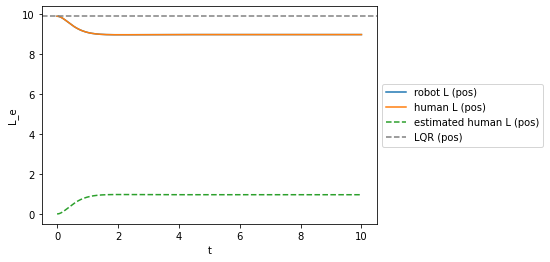

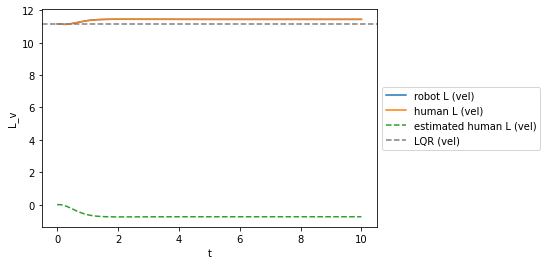

In [985]:
QHh[-1]

array([[ 0.01006127,  0.061439  ],
       [ 0.05636216, -0.1094029 ]])

In [887]:
QH

array([[1., 0.],
       [0., 0.]])

In [757]:
# plt.plot(t_,QHh[:,0,0])
# # plt.plot(t_,QH[0,0])

# plt.title('QH,e')
# plt.plot(t_,QHh[:,1,1])
# plt.title('QH,v')

# plt.plot(t_,la.norm(la.norm(QHh,axis = 2),axis = 1))
# plt.axhline(y=la.norm(QH), color='grey', linestyle='--')

## cooperation: Q+Qh = C = diag(200,0)

robot start with Q = diag(100,0) and robot assume human's initial Q is also diag(100,0). estimated initial position is pos=(0,0)
human is actually doing a fixed QH

In [845]:
# cooperation, Q+Qh = C
C = dt * np.array([[200,0],[0,0]])

t = 0
#DT system
T = 10 #total time (s)
dt = 1e-2
t_ = np.linspace(0,T,int(T/dt))
A = np.identity(2) + dt * np.array([[0, 1],[0,-(1/I)*D]])
B = dt * np.array([[0],[1/I]])

xd = 0.1 #target position +10cm

#initialize Q, QHh, u, uHh, sh, PHh
x = np.zeros((int(T/dt)+1,2)) #x[0] = position, x[1] = velocity
s = np.zeros((int(T/dt)+1,2)) #state, s = x-xd
s[0] = np.array([x[0,0]-xd,x[0,1]]) #get position and velocity, form the state s
sh = np.zeros((int(T/dt)+1,2)) #estimated state
sh[0] = np.array([x[0,0]-xd,x[0,1]]) 
# sh[0] = np.array([-0.1,0])#-0.1*np.random.rand(2)
se = np.zeros((int(T/dt)+1,2)) #state estimation error
u = np.zeros((int(T/dt),1)) #robot and human inputs
uH = np.zeros((int(T/dt),1)) #robot and human inputs
uHh = np.zeros((int(T/dt),1)) #robot and human inputs


Q = dt * np.array([[100,0],[0,0]])  #robot running state cost, time-invariant
QH = dt * np.array([[100,0],[0,0]])
# QH = np.zeros((int(T/dt)+1,2,2))
# QH[0] = dt * np.array([[100,0],[0,0]])  #human running state cost, time-invariant
QHh = np.zeros((int(T/dt),2,2))  #robot estimate human running state cost, time-variant
QHh[0] = dt * np.array([[100,0],[0,0]]) 
R = dt * np.array([[1]]) # running control cost

P = np.zeros((int(T/dt),2,2)) #robot P that solves the riccati eqn
PH = np.zeros((int(T/dt),2,2)) #robot P that solves the riccati eqn

PHh = np.zeros((int(T/dt)+1,2,2)) #human P that solves the riccati eqn
PHh[0] = la.solve_discrete_are(A,B,QHh[0],R)
L = np.zeros((int(T/dt),1,2))
LH = np.zeros((int(T/dt),1,2))
LHh = np.zeros((int(T/dt),1,2))

c = np.zeros((int(T/dt),1))
cH = np.zeros((int(T/dt),1))
cHh = np.zeros((int(T/dt),1))

#set Gamma and alpha
G = dt*np.array([[10,0],[0,1]]) #Gamma, observer gain
a = 10**3 #learning rate

In [848]:
for t in range(int(T/dt)):
    # (1) closed loop system observer
    # calculate the estimation error se and estimated state sh
    se[t] = sh[t] - s[t]
    sh[t+1] = np.dot(A,sh[t]) + np.dot(B, u[t]+uHh[t]) - np.dot(G,se[t])

    # (2) identity control of human
    # update PHh, and estimated human control gain L and u = -Ls
    PHh[t+1] = PHh[t] + dt * np.outer( a*(se[t]-s[t]), s[t] ) 
    LHh[t] = (la.inv(R+B.T@PHh[t]@B))@(B.T@PHh[t]@A) #if CT: np.dot (B.T , PHh[t]) 
    uHh[t] = -np.dot(LHh[t],s[t])

    # (3) robot control input
    Ar = A - np.dot(B,LHh[t])
    P[t] = la.solve_discrete_are(Ar,B,Q,R)
    L[t] = (la.inv(R+B.T@P[t]@B))@(B.T@P[t]@Ar) #if CT: np.dot (B.T , P[t]) 
    u[t] = -np.dot(L[t],s[t]) #output 

    # (4) calculate estimated human cost function QHh (from DARE)
    AH = A - np.dot(B,L[t])
    QHh[t] = PHh[t] - AH.T@PHh[t]@AH + AH.T@PHh[t]@B@ (la.inv(R+B.T@PHh[t]@B)) @B.T@PHh[t]@AH #output
    # if CT: QHh[t] = PHh[t]@B@B.T@PHh[t] - AH.T@PHh[t] - PHh[t]@AH 

    #what human is actually doing:
    PH[t] = la.solve_discrete_are(AH,B,QH,R)
    LH[t] = (la.inv(R+B.T@PH[t]@B))@(B.T@PH[t]@AH) #if CT: np.dot (B.T , P[t]) 
    uH[t] = -np.dot(LH[t],s[t]) #output 

    #costs
    c[t] = np.dot(np.dot(s[t],Q),s[t]) + np.dot(np.dot(u[t],R),u[t]) #machine cost
    cH[t] = np.dot(np.dot(s[t],QH),s[t]) + np.dot(np.dot(uH[t],R),uH[t])  #estimated human cost
    cHh[t] = np.dot(np.dot(s[t],QHh[t]),s[t]) + np.dot(np.dot(uHh[t],R),uHh[t])  #estimated human cost

    # calculate next state
    s[t+1] = np.dot(A,s[t]) + np.dot(B, u[t]+uH[t])   
   

In [847]:
# cooperation, update a new robot Q, then run the above algorithm again
# Q = C - QHh[-1]
Q = np.array([[dt*200 - QHh[-1,0,0],0],[0,QHh[-1,1,1]]])    
Q

array([[-0.05778885,  0.        ],
       [ 0.        ,  0.01367887]])

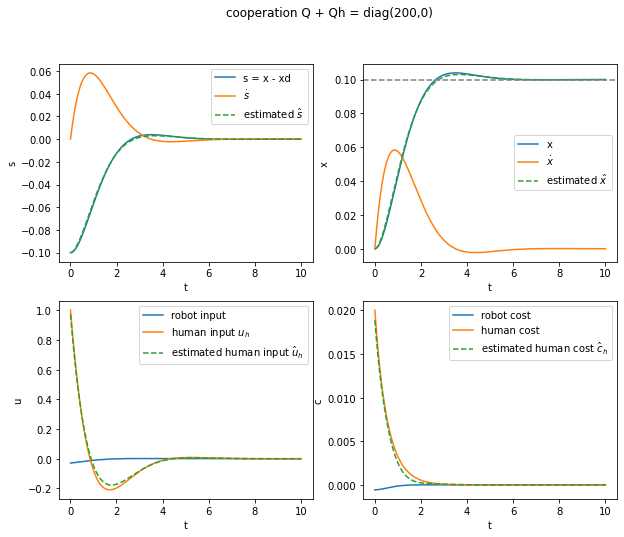

In [849]:
fig,axs = plt.subplots(2,2,figsize = (10,8))
ax = axs[0,0]
ax.plot(t_,s[:-1,0], label= 's = x - xd')
ax.plot(t_,s[:-1,1], label= r'$\dot s$')
ax.plot(t_,sh[:,0][:-1], '--',label= r'estimated $\hat s$')
ax.set_ylabel('s')
ax.set_xlabel('t')
ax.legend()

ax = axs[0,1]
# xd = np.zeros((len(t_))) + 0.1 #make xd a fixed target of 10 cm
ax.plot(t_,s[:-1,0]+ xd, label= 'x')
ax.plot(t_,s[:-1,1], label= r'$\dot x$')
ax.plot(t_,sh[:,0][:-1]+ xd, '--',label= r'estimated $\hat x$')
ax.axhline(y=0.1, color='grey', linestyle='--')
ax.set_ylabel('x')
ax.set_xlabel('t')
ax.legend()

ax = axs[1,0]
ax.plot(t_[1:],u[1:], label= 'robot input')
ax.plot(t_[1:],uH[1:], label= 'human input $u_h$')
ax.plot(t_[1:],uHh[1:], '--',label= 'estimated human input $\hat u_h$')
ax.set_ylabel('u')
ax.set_xlabel('t')
ax.legend()

ax = axs[1,1]
ax.plot(t_[1:],c[1:], label= 'robot cost')
ax.plot(t_[1:],cH[1:], label= 'human cost')
ax.plot(t_[1:],cHh[1:], '--',label= 'estimated human cost $\hat c_h$')
ax.set_ylabel('c')
ax.set_xlabel('t')
ax.legend()

fig.suptitle('cooperation Q + Qh = diag(200,0)')
# plt.tight_layout()
plt.show()

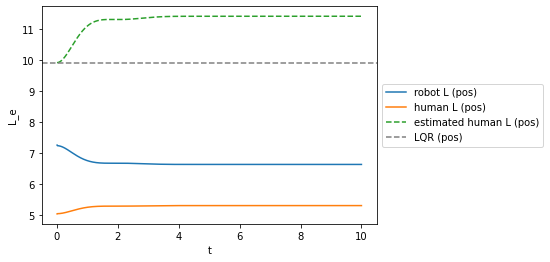

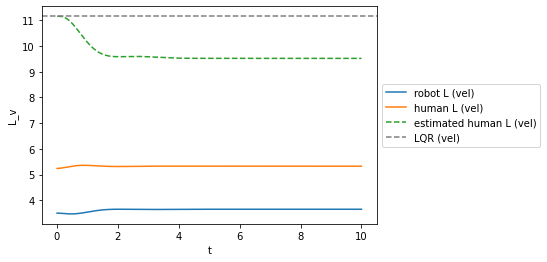

In [811]:
plt.plot(t_[1:],L[1:,:,0], label= 'robot L (pos)')
plt.plot(t_[1:],LH[1:,:,0], label= 'human L (pos)')
plt.plot(t_[1:],LHh[1:,:,0],'--', label= 'estimated human L (pos)')
plt.axhline(y=K[0,0], color='grey', linestyle='--', label= 'LQR (pos)')
plt.ylabel('L_e')
plt.xlabel('t')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.plot(t_[1:],L[1:,:,1],  label= 'robot L (vel)')
plt.plot(t_[1:],LH[1:,:,1], label= 'human L (vel)')
plt.plot(t_[1:],LHh[1:,:,1], '--',label= 'estimated human L (vel)')
plt.axhline(y=K[0,1], color='grey', linestyle='--', label= 'LQR (vel)')
plt.ylabel('L_v')
plt.xlabel('t')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

idea:

noisy human input with probablity

## backup code

In [ ]:
# for t in range(int(T/dt)):
# # for t in range(10):
# # for t in [0,1,2]:
    
#     # (1) closed loop system observer
#     # calculate the estimation error se and estimated state sh
#     se[t] = sh[t] - s[t]
#     sh[t+1] = np.dot(A,sh[t]) + np.dot(B, u[t]+uHh[t]) - np.dot(G,se[t])

#     # (2) identity control of human
#     # update PHh, and estimated human control gain L and u = -Ls
#     PHh[t+1] = dt * np.outer( a*(se[t]-s[t]), s[t] ) 
#     LHh[t] = np.dot (B.T , PHh[t])
#     uHh[t] = -np.dot (LHh[t],s[t])

#     # (3) robot control input
#     Ar = A - np.dot(B,LHh[t])
#     P[t] = la.solve_discrete_are(Ar,B,Q[t],R)
#     u[t] = -B.T@P[t]@s[t] #output

#     # (4) calculate estimated human cost function QHh (from DARE)
#     L = np.dot(B.T, P[t])
#     AH = A - np.dot(B,L)
#     # QHh[t] = PHh[t]@B@B.T@PHh[t] - AH.T@PHh[t] - PHh[t]@AH 
#     QHh[t] = PHh[t] - AH.T@PHh[t]@AH + AH.T@PHh[t]@B@la.inv(R+B.T@PHh[t]@B)@B.T@PHh[t]@AH #output
   
#     # calculate next state
#     s[t+1] = np.dot(A,s[t]) + np.dot(B, u[t]+uHh[t])        




In [ ]:
# for t in range(int(T/dt)):
#     # (1) closed loop system observer
#     # calculate the estimation error se and estimated state sh
#     se[t] = sh[t] - s[t]
#     sh[t+1] = np.dot(A,sh[t]) + np.dot(B, u[t]+uHh[t]) - np.dot(G,se[t])

#     # (2) identity control of human
#     # update PHh, and estimated human control gain L and u = -Ls
#     PHh[t+1] = PHh[t] + dt * np.outer( a*(se[t]-s[t]), s[t] ) 
#     LHh[t] = (la.inv(R+B.T@PHh[t]@B))@(B.T@PHh[t]@A) #if CT: np.dot (B.T , PHh[t]) 
#     uHh[t] = -np.dot(LHh[t],s[t])

#     # (3) robot control input
#     Ar = A - np.dot(B,LHh[t])
#     P[t] = la.solve_discrete_are(Ar,B,Q,R)
#     L[t] = (la.inv(R+B.T@P[t]@B))@(B.T@P[t]@Ar) #if CT: np.dot (B.T , P[t]) 
#     u[t] = -np.dot(L[t],s[t]) #output 

#     # (4) calculate estimated human cost function QHh (from DARE)
#     AH = A - np.dot(B,L[t])
#     QHh[t] = PHh[t] - AH.T@PHh[t]@AH + AH.T@PHh[t]@B@ (la.inv(R+B.T@PHh[t]@B)) @B.T@PHh[t]@AH #output
#     # if CT: QHh[t] = PHh[t]@B@B.T@PHh[t] - AH.T@PHh[t] - PHh[t]@AH 

#     #costs
#     c[t] = np.dot(np.dot(s[t],Q),s[t]) + np.dot(np.dot(u[t],R),u[t]) #machine cost
#     cH[t] = np.dot(np.dot(s[t],QHh[t]),s[t]) + np.dot(np.dot(uHh[t],R),uHh[t])  #estimated human cost

#     # calculate next state
#     s[t+1] = np.dot(A,s[t]) + np.dot(B, u[t]+uHh[t])    